# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
from scipy.interpolate import interp1d
import scipy.stats as stats
import copy

from minot.ClusterTools import map_tools
import pitszi
import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV  = 4*u.arcmin
los_reso = 30*u.kpc
los_size = 8*u.Mpc

# Analysis parameters
ps_mask_lim = 0.1 # mJy
mask_theta = 2*u.arcmin
Nsim = 100
apply_radial_model = True

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
TF = libs.get_TF()

In [4]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, ps_mask_lim)

# Define model

In [5]:
#========== cluster model
cl_model1 = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                         redshift=cl_redshift, M500=cl_M500, 
                         silent=True, output_dir=outdir)
cl_model1.set_pressure_profile_universal_param('A10MD')

cl_model1.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                        'statistics':'gaussian',
                                        'Norm': 0.5,
                                        'slope': -11/3.0,
                                        'Linj': 2000*u.kpc,
                                        'Ldis': 1*u.kpc}
cl_model1.map_header = cl_head
cl_model1.los_reso  = los_reso
cl_model1.los_size  = los_size
cl_model1.R_truncation = 10*u.Mpc

cl_model2 = copy.deepcopy(cl_model1)
cl_model2.model_pressure_fluctuation['Linj'] = 500*u.kpc

cl_model3 = copy.deepcopy(cl_model1)
cl_model3.model_pressure_fluctuation['Linj'] = 200*u.kpc

cl_model4 = copy.deepcopy(cl_model2)
cl_model4.set_pressure_profile_universal_param('A10CC')

# Analysis

### Test Pk recovery from projection

In [6]:
# Build inference for accessing Pk models and tools
cl_data = pitszi.Data(cl_img, cl_head, silent=True)
cl_data.noise_mc = cl_noise
cl_inf1 = pitszi.InferenceFluctuation(cl_data, cl_model1, silent=True)
cl_inf1.pk_setup(Nmc=1)
cl_inf2 = pitszi.InferenceFluctuation(cl_data, cl_model2, silent=True)
cl_inf2.pk_setup(Nmc=1)
cl_inf3 = pitszi.InferenceFluctuation(cl_data, cl_model3, silent=True)
cl_inf3.pk_setup(Nmc=1)
cl_inf4 = pitszi.InferenceFluctuation(cl_data, cl_model4, silent=True)
cl_inf4.pk_setup(Nmc=1)

In [15]:
# Defines the binning
pk_Nbin = 50
kedges = np.linspace(1/np.amax(cl_model1.get_map_fov(physical=True).to_value('kpc')), 
                     1/cl_model1.get_map_reso(physical=True).to_value('kpc'), 
                     pk_Nbin+1)
kvals = 0.5 * (kedges[1:] + kedges[:-1])

In [8]:
# Extract the true pk
ktrue, pktrue1 = cl_model1.get_pressure_fluctuation_spectrum()
ktrue, pktrue2 = cl_model2.get_pressure_fluctuation_spectrum()
ktrue, pktrue3 = cl_model3.get_pressure_fluctuation_spectrum()
ktrue, pktrue4 = cl_model4.get_pressure_fluctuation_spectrum()

# Projection and bining
k2d_flat = cl_inf1._k2d_norm_kpc.flatten()
idx_sort = np.argsort(k2d_flat)
revidx   = np.argsort(idx_sort)
k3d_test = np.sort(k2d_flat)
wok = (k3d_test > 0)
k3d_test_clean = k3d_test[wok]
_, pk3d_test_clean1 = cl_inf1.model.get_pressure_fluctuation_spectrum(k3d_test_clean*u.kpc**-1)
_, pk3d_test_clean2 = cl_inf2.model.get_pressure_fluctuation_spectrum(k3d_test_clean*u.kpc**-1)
_, pk3d_test_clean3 = cl_inf3.model.get_pressure_fluctuation_spectrum(k3d_test_clean*u.kpc**-1)
_, pk3d_test_clean4 = cl_inf4.model.get_pressure_fluctuation_spectrum(k3d_test_clean*u.kpc**-1)
pk3d_test1      = np.zeros(len(k3d_test))
pk3d_test2      = np.zeros(len(k3d_test))
pk3d_test3      = np.zeros(len(k3d_test))
pk3d_test4      = np.zeros(len(k3d_test))
pk3d_test1[wok] = pk3d_test_clean1.to_value('kpc3')
pk3d_test1      = pk3d_test1[revidx] # same shape as k2d_flat
pk2d_flat1 = pk3d_test1 * cl_inf1._conv_pk2d3d # Unit == kpc2, 2d grid
pk3d_test2[wok] = pk3d_test_clean2.to_value('kpc3')
pk3d_test2      = pk3d_test2[revidx] # same shape as k2d_flat
pk2d_flat2 = pk3d_test2 * cl_inf2._conv_pk2d3d # Unit == kpc2, 2d grid
pk3d_test3[wok] = pk3d_test_clean3.to_value('kpc3')
pk3d_test3      = pk3d_test3[revidx] # same shape as k2d_flat
pk2d_flat3 = pk3d_test3 * cl_inf3._conv_pk2d3d # Unit == kpc2, 2d grid
pk3d_test4[wok] = pk3d_test_clean4.to_value('kpc3')
pk3d_test4      = pk3d_test4[revidx] # same shape as k2d_flat
pk2d_flat4 = pk3d_test4 * cl_inf4._conv_pk2d3d # Unit == kpc2, 2d grid

pktruebin1,_,_ = stats.binned_statistic(k2d_flat, pk2d_flat1, statistic='mean', bins=kedges)
pktruebin2,_,_ = stats.binned_statistic(k2d_flat, pk2d_flat2, statistic='mean', bins=kedges)
pktruebin3,_,_ = stats.binned_statistic(k2d_flat, pk2d_flat3, statistic='mean', bins=kedges)
pktruebin4,_,_ = stats.binned_statistic(k2d_flat, pk2d_flat4, statistic='mean', bins=kedges)

In [9]:
pkmeas1 = np.zeros((Nsim, len(pktruebin1)))
pkmeas2 = np.zeros((Nsim, len(pktruebin2)))
pkmeas3 = np.zeros((Nsim, len(pktruebin3)))
pkmeas4 = np.zeros((Nsim, len(pktruebin4)))
for i in range(Nsim):
    if i%10 == 0: print(i, '/', Nsim)
        
    ysim = cl_model1.get_sz_map()
    ybar = cl_model1.get_sz_map(no_fluctuations=True)
    img = (ysim - ybar)/ybar
    _, pkmeas_i = pitszi.utils_pk.extract_pk2d(img, cl_model1.map_reso.to_value('rad')*cl_model1.D_ang.to_value('kpc'),kedges=kedges)
    pkmeas1[i,:] = pkmeas_i
    
    ysim = cl_model2.get_sz_map()
    ybar = cl_model2.get_sz_map(no_fluctuations=True)
    img = (ysim - ybar)/ybar
    _, pkmeas_i = pitszi.utils_pk.extract_pk2d(img, cl_model2.map_reso.to_value('rad')*cl_model2.D_ang.to_value('kpc'),kedges=kedges)
    pkmeas2[i,:] = pkmeas_i
    
    ysim = cl_model3.get_sz_map()
    ybar = cl_model3.get_sz_map(no_fluctuations=True)
    img = (ysim - ybar)/ybar
    _, pkmeas_i = pitszi.utils_pk.extract_pk2d(img, cl_model3.map_reso.to_value('rad')*cl_model3.D_ang.to_value('kpc'),kedges=kedges)
    pkmeas3[i,:] = pkmeas_i
    
    ysim = cl_model4.get_sz_map()
    ybar = cl_model4.get_sz_map(no_fluctuations=True)
    img = (ysim - ybar)/ybar
    _, pkmeas_i = pitszi.utils_pk.extract_pk2d(img, cl_model4.map_reso.to_value('rad')*cl_model4.D_ang.to_value('kpc'),kedges=kedges)
    pkmeas4[i,:] = pkmeas_i

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


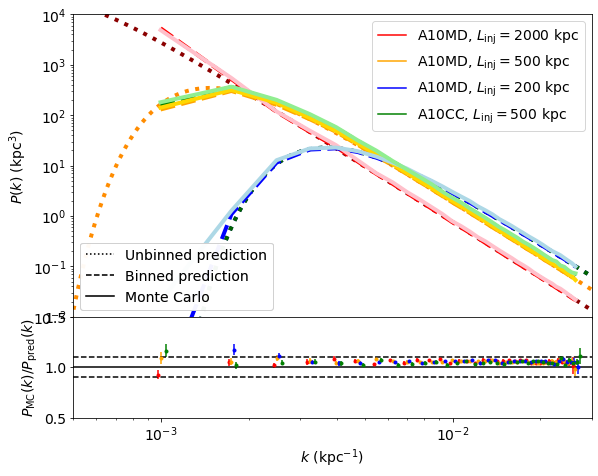

In [17]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 7))
frame1 = fig.add_axes((.15,.3,.8,.6))
plt.loglog(ktrue.to_value('kpc-1'), pktrue1.to_value('kpc3')*cl_inf1._conv_pk2d3d, color='darkred', lw=4, ls=':')
plt.loglog(ktrue.to_value('kpc-1'), pktrue2.to_value('kpc3')*cl_inf2._conv_pk2d3d, color='darkorange', lw=4, ls=':')
plt.loglog(ktrue.to_value('kpc-1'), pktrue3.to_value('kpc3')*cl_inf3._conv_pk2d3d, color='darkblue', lw=4, ls=':')
plt.loglog(ktrue.to_value('kpc-1'), pktrue3.to_value('kpc3')*cl_inf3._conv_pk2d3d, color='darkgreen', lw=4, ls=':')
plt.loglog(kvals, pktruebin1, color='red', lw=4, ls='--')
plt.loglog(kvals, pktruebin2, color='orange', lw=4, ls='--')
plt.loglog(kvals, pktruebin3, color='blue', lw=4, ls='--')
plt.loglog(kvals, pktruebin4, color='green', lw=4, ls='--')
plt.loglog(kvals, np.mean(pkmeas1, axis=0), color='pink', lw=4, ls='-')
plt.loglog(kvals, np.mean(pkmeas2, axis=0), color='gold', lw=4, ls='-')
plt.loglog(kvals, np.mean(pkmeas3, axis=0), color='lightblue', lw=4, ls='-')
plt.loglog(kvals, np.mean(pkmeas4, axis=0), color='lightgreen', lw=4, ls='-')
plt.ylim(1e-2, 1e4)
plt.xlim(5e-4, 3e-2)
plt.ylabel(r'$P(k)$ (kpc$^3$)')

ax = plt.gca()
line0, = ax.plot([0],[0], ls="-", color='red', label=r'A10MD, $L_{\rm inj} = 2000$ kpc')
line1, = ax.plot([0],[0], ls="-", color='orange', label=r'A10MD, $L_{\rm inj} = 500$ kpc')
line2, = ax.plot([0],[0], ls="-", color='blue', label=r'A10MD, $L_{\rm inj} = 200$ kpc')
line3, = ax.plot([0],[0], ls="-", color='green', label=r'A10CC, $L_{\rm inj} = 500$ kpc')

linea, = ax.plot([0],[0], color='k', ls=':', label='Unbinned prediction')
lineb, = ax.plot([0],[0], color='k', ls='--', label='Binned prediction')
linec, = ax.plot([0],[0], color='k', ls='-', label='Monte Carlo')

legend1 = ax.legend(handles=[line0,line1,line2,line3],       loc='upper right')
legend2 = ax.legend(handles=[linea,lineb,linec], loc='lower left')
ax.add_artist(legend1)
ax.add_artist(legend2)

frame2 = fig.add_axes((.15,.1,.8,.2))
plt.errorbar(0.98*kvals, np.mean(pkmeas1, axis=0)/pktruebin1, 
             np.std(pkmeas1, axis=0)/pktruebin1/Nsim**0.5, ls='', marker='.', color='red')
plt.errorbar(kvals, np.mean(pkmeas2, axis=0)/pktruebin2, 
             np.std(pkmeas2, axis=0)/pktruebin2/Nsim**0.5, ls='', marker='.', color='orange')
plt.errorbar(1.02*kvals, np.mean(pkmeas3, axis=0)/pktruebin3, 
             np.std(pkmeas3, axis=0)/pktruebin3/Nsim**0.5, ls='', marker='.', color='blue')
plt.errorbar(1.04*kvals, np.mean(pkmeas4, axis=0)/pktruebin4, 
             np.std(pkmeas4, axis=0)/pktruebin4/Nsim**0.5, ls='', marker='.', color='green')
plt.axhline(1, color='k', ls='-')
plt.axhline(0.9, color='k', ls='--')
plt.axhline(1.1, color='k', ls='--')
plt.xscale('log')
plt.xlim(5e-4, 3e-2)
plt.ylim(0.5,1.5)
plt.xlabel('$k$ (kpc$^{-1}$)')
plt.ylabel(r'$P_{\rm MC}(k) / P_{\rm pred}(k)$')
plt.savefig(outdir+'/compare_pk_reco.pdf')

### Test Pk recovery including beam, mask, TF

In [11]:
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))*2

In [12]:
# Build inference for accessing Pk models and tools
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)

cl_inf1 = pitszi.InferenceFluctuation(cl_data, cl_model1, silent=True)
cl_inf1.kbin_Nbin = Nbins_pk
cl_inf1.kbin_min = kmin_pk
cl_inf1.kbin_max = kmax_pk
cl_inf1.nuisance_Abkg = 0
cl_inf1.nuisance_Anoise = 0
cl_inf1.method_w8 = cl_mask
cl_inf1.pk_setup(Nmc=Nsim)

cl_inf2 = pitszi.InferenceFluctuation(cl_data, cl_model2, silent=True)
cl_inf2.kbin_Nbin = Nbins_pk
cl_inf2.kbin_min = kmin_pk
cl_inf2.kbin_max = kmax_pk
cl_inf2.nuisance_Abkg = 0
cl_inf2.nuisance_Anoise = 0
cl_inf2.method_w8 = cl_mask
cl_inf2.pk_setup(Nmc=Nsim)

cl_inf3 = pitszi.InferenceFluctuation(cl_data, cl_model3, silent=True)
cl_inf3.kbin_Nbin = Nbins_pk
cl_inf3.kbin_min = kmin_pk
cl_inf3.kbin_max = kmax_pk
cl_inf3.nuisance_Abkg = 0
cl_inf3.nuisance_Anoise = 0
cl_inf3.method_w8 = cl_mask
cl_inf3.pk_setup(Nmc=Nsim)

cl_inf4 = pitszi.InferenceFluctuation(cl_data, cl_model4, silent=True)
cl_inf4.kbin_Nbin = Nbins_pk
cl_inf4.kbin_min = kmin_pk
cl_inf4.kbin_max = kmax_pk
cl_inf4.nuisance_Abkg = 0
cl_inf4.nuisance_Anoise = 0
cl_inf4.method_w8 = cl_mask
cl_inf4.pk_setup(Nmc=Nsim)

In [19]:
kvals = cl_inf1._kctr_kpc

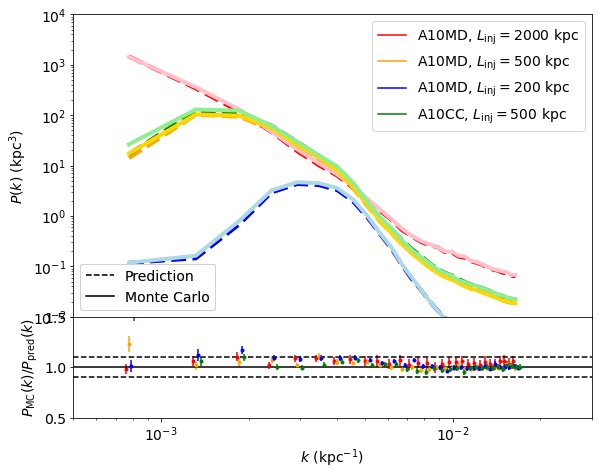

In [20]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 7))
frame1 = fig.add_axes((.15,.3,.8,.6))
plt.loglog(kvals, cl_inf1.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), color='red', lw=4, ls='--')
plt.loglog(kvals, cl_inf2.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), color='orange', lw=4, ls='--')
plt.loglog(kvals, cl_inf3.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), color='blue', lw=4, ls='--')
plt.loglog(kvals, cl_inf4.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), color='green', lw=4, ls='--')
plt.loglog(kvals, cl_inf1._pk2d_modref, color='pink', lw=4, ls='-')
plt.loglog(kvals, cl_inf2._pk2d_modref, color='gold', lw=4, ls='-')
plt.loglog(kvals, cl_inf3._pk2d_modref, color='lightblue', lw=4, ls='-')
plt.loglog(kvals, cl_inf4._pk2d_modref, color='lightgreen', lw=4, ls='-')
plt.ylim(1e-2, 1e4)
plt.xlim(5e-4, 3e-2)
plt.ylabel(r'$P(k)$ (kpc$^3$)')


ax = plt.gca()
line0, = ax.plot([0],[0], ls="-", color='red', label=r'A10MD, $L_{\rm inj} = 2000$ kpc')
line1, = ax.plot([0],[0], ls="-", color='orange', label=r'A10MD, $L_{\rm inj} = 500$ kpc')
line2, = ax.plot([0],[0], ls="-", color='blue', label=r'A10MD, $L_{\rm inj} = 200$ kpc')
line3, = ax.plot([0],[0], ls="-", color='green', label=r'A10CC, $L_{\rm inj} = 500$ kpc')

linea, = ax.plot([0],[0], color='k', ls='--', label='Prediction')
lineb, = ax.plot([0],[0], color='k', ls='-', label='Monte Carlo')

legend1 = ax.legend(handles=[line0,line1,line2,line3],       loc='upper right')
legend2 = ax.legend(handles=[linea,lineb], loc='lower left')
ax.add_artist(legend1)
ax.add_artist(legend2)
    
frame2 = fig.add_axes((.15,.1,.8,.2))
plt.errorbar(0.98*kvals, cl_inf1._pk2d_modref/cl_inf1.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), 
             cl_inf1._pk2d_modref_rms/cl_inf1.get_pk2d_model_proj(physical=True)[1].to_value('kpc2')/Nsim**0.5, ls='', marker='.', color='red')
plt.errorbar(kvals, cl_inf2._pk2d_modref/cl_inf2.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), 
             cl_inf2._pk2d_modref_rms/cl_inf2.get_pk2d_model_proj(physical=True)[1].to_value('kpc2')/Nsim**0.5, ls='', marker='.', color='orange')
plt.errorbar(1.02*kvals, cl_inf3._pk2d_modref/cl_inf3.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), 
             cl_inf3._pk2d_modref_rms/cl_inf3.get_pk2d_model_proj(physical=True)[1].to_value('kpc2')/Nsim**0.5, ls='', marker='.', color='blue')
plt.errorbar(1.04*kvals, cl_inf4._pk2d_modref/cl_inf4.get_pk2d_model_proj(physical=True)[1].to_value('kpc2'), 
             cl_inf4._pk2d_modref_rms/cl_inf4.get_pk2d_model_proj(physical=True)[1].to_value('kpc2')/Nsim**0.5, ls='', marker='.', color='green')
plt.axhline(1, color='k', ls='-')
plt.axhline(0.9, color='k', ls='--')
plt.axhline(1.1, color='k', ls='--')
plt.xscale('log')
plt.xlim(5e-4, 3e-2)
plt.ylim(0.5,1.5)
plt.xlabel('$k$ (kpc$^{-1}$)')
plt.ylabel(r'$P_{\rm MC}(k) / P_{\rm pred}(k)$')
plt.savefig(outdir+'/compare_pk_reco2.pdf')